**Name**: LIM YUAN HER

**Admin No**: 20A459H

# Human identification via walking posture

*   **Objective**: Develop a NN-based algorithm to recognize a person from the video footage of walking posture

*   **Method**: Extract keypoint data from training videos using AlphaPose/OpenPose pose estimation models to be used to train a LSTM-based neural network model for person recognition (classification)

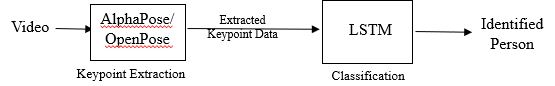

## 1 Preparation
*   Import required libraries, set random seed, setup google drive connection



In [ ]:
# Import libraries
from numpy import array
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, BatchNormalization
from tensorflow.keras.layers import Flatten, LSTM, GRU
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

from datetime import datetime
import pandas as pd
import numpy as np
import re

import os
import numpy as np
import math
import random
import glob
import shutil
from os.path import exists, join, basename, splitext
from pathlib import Path
import time

import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc

In [ ]:
# Set seed
tf.random.set_seed(33)
np.random.seed(33)
random.seed(33)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:
4/1AY0e-g63vNtwwe65Rv52HuWKY8-ZbXdkPwO9LHISJ451fDQCYDcfS_eopjw
Mounted at /content/drive


## 2 Dataset
*   Data used is from the ***GaHu-Video: Parametrization system for human gait  recognition*** dataset downloadable from:
> https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/gprg4s73v4-2.zip






## 3 Video Keypoint Data Extraction

**Note:** Use OpenPose/AlphaPose pose estimation models to extract keypoint data from dataset videos (see below for illustrated keypoint data definition):
>* **OpenPose:** https://github.com/CMU-Perceptual-Computing-Lab/openpose
>* **AlphaPose:** https://github.com/MVIG-SJTU/AlphaPose




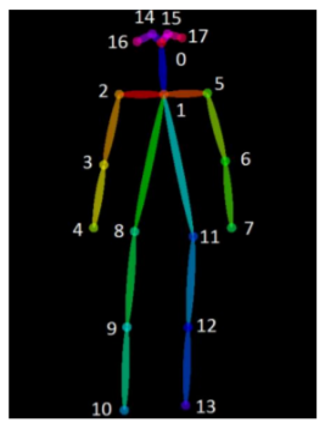

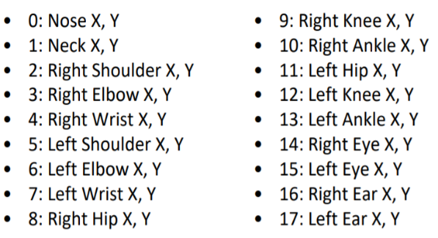

### 3.1 OpenPose
*   Use OpenPose to extract keypoint data from dataset videos



#### 3.1.1 Installation

In [ ]:
git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake -DBUILD_PYTHON=ON .. && make -j`nproc`
  
from IPython.display import YouTubeVideo

Selecting previously unselected package libgflags2.2.
(Reading database ... 145483 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

In [ ]:
os.chdir("/content/openpose/build/python/openpose")
!make install

-- GCC detected, adding compile flags
-- GCC detected, adding compile flags
-- Building with CUDA.
-- CUDA detected: 10.1
-- Found cuDNN: ver. 7.6.5 found (include: /usr/include, library: /usr/lib/x86_64-linux-gnu/libcudnn.so)
-- Added CUDA NVCC flags for: sm_75
-- Found cuDNN: ver. 7.6.5 found (include: /usr/include, library: /usr/lib/x86_64-linux-gnu/libcudnn.so)
-- Found gflags  (include: /usr/include, library: /usr/lib/x86_64-linux-gnu/libgflags.so)
-- Found glog    (include: /usr/include, library: /usr/lib/x86_64-linux-gnu/libglog.so)
-- Caffe will be downloaded from source now. NOTE: This process might take several minutes depending
        on your internet connection.
-- Caffe has already been downloaded.
HEAD is now at 1807aada Added Ampere arch's (CUDA11)
-- Caffe will be built from source now.
-- Adding Example calibration.bin
-- Adding Example tutorial_add_module_custom_post_processing.bin
-- Adding Example tutorial_api_thread_1_user_processing_function.bin
-- Adding Example

In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

#### 3.1.2 Generate Keypoints

##### 3.1.2.1 GaHu

In [ ]:
filepath = '/content/drive/MyDrive/Datasets/GaHu.zip'
!mkdir /content/GaHu
!unzip {filepath} -d /content/GaHu

In [ ]:
path = "/content/GaHu"
#subpaths = [dirpaths for dirpaths, dirnames, filenames in os.walk(path) if not dirnames and "_Left" not in dirpaths and "_Right" not in dirpaths]
subpaths = [dirpaths for dirpaths, dirnames, filenames in os.walk(path) if not dirnames]
print(subpaths)

['/content/GaHu/Track_C/Sx_Track 3_Right', '/content/GaHu/Track_C/Sx_Track 3_Left', '/content/GaHu/Track_C/Sx_Track 3', '/content/GaHu/Track_B/Sx_Track 2', '/content/GaHu/Track_B/Sx_Track 2_Left', '/content/GaHu/Track_B/Sx_Track 2_Right', '/content/GaHu/Track_A/Sx_Track 1_Left', '/content/GaHu/Track_A/Sx_Track 1', '/content/GaHu/Track_A/Sx_Track 1_Right']


In [ ]:
os.chdir(subpaths[0])

subjects = []
for i, file in enumerate(sorted(glob.glob("*.avi"))):
  split_filename = file.split("_")
  subjects.append(split_filename[0])
print(subjects)

['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010', 'S011', 'S012', 'S013', 'S014', 'S015', 'S016', 'S017', 'S018', 'S019', 'S020', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S029', 'S030', 'S031', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S038', 'S039', 'S040', 'S041', 'S042', 'S043', 'S044']


In [ ]:
files_to_process = []

for subject in subjects:
  for subpath in subpaths:
    directory = os.listdir(subpath)
    for fname in directory:
      if subject in fname:
        filepath = os.path.join(subpath, fname)
        files_to_process.append(filepath)
print(files_to_process)

['/content/GaHu/Track_C/Sx_Track 3_Right/S001_T3_R.avi', '/content/GaHu/Track_C/Sx_Track 3_Left/S001_T3_L.avi', '/content/GaHu/Track_C/Sx_Track 3/S001_T3.avi', '/content/GaHu/Track_B/Sx_Track 2/S001_T2.avi', '/content/GaHu/Track_B/Sx_Track 2_Left/S001_T2_L.avi', '/content/GaHu/Track_B/Sx_Track 2_Right/S001_T2_R.avi', '/content/GaHu/Track_A/Sx_Track 1_Left/S001_T1_L.avi', '/content/GaHu/Track_A/Sx_Track 1/S001_T1.avi', '/content/GaHu/Track_A/Sx_Track 1_Right/S001_T1_R.avi', '/content/GaHu/Track_C/Sx_Track 3_Right/S002_T3_R.avi', '/content/GaHu/Track_C/Sx_Track 3_Left/S002_T3_L.avi', '/content/GaHu/Track_C/Sx_Track 3/S002_T3.avi', '/content/GaHu/Track_B/Sx_Track 2/S002_T2.avi', '/content/GaHu/Track_B/Sx_Track 2_Left/S002_T2_L.avi', '/content/GaHu/Track_B/Sx_Track 2_Right/S002_T2_R.avi', '/content/GaHu/Track_A/Sx_Track 1_Left/S002_T1_L.avi', '/content/GaHu/Track_A/Sx_Track 1/S002_T1.avi', '/content/GaHu/Track_A/Sx_Track 1_Right/S002_T1_R.avi', '/content/GaHu/Track_C/Sx_Track 3_Right/S003_

In [ ]:
import glob, os

basedir = "/content"
tempOutputFile = "/content/temp.avi"
os.chdir(basedir)

for file in files_to_process:
  filename = os.path.splitext(os.path.basename(file))[0]
  filename_split = filename.split("_")
  subject = filename_split[0]

  if(len(filename_split) == 2):
    repetition = "R" + filename_split[1][-1]
  else:
    repetition = "R" + filename_split[1][-1] + filename_split[2] 
  print(filename, subject, repetition)

  !rm {tempOutputFile}
  !mkdir -p {basedir}/output/OpenPose/{subject}/{repetition}
  os.chdir("/content/openpose")

  #!ffmpeg -y -loglevel info -i '{file}' -t 10 /content/video.mp4
  
  !./build/examples/openpose/openpose.bin --video '{file}' --write_json {basedir}/output/OpenPose/{subject}/{repetition} --display 0  --write_video {tempOutputFile}
  # convert the result into MP4
  !ffmpeg -y -loglevel info -i {tempOutputFile} {basedir}/output/OpenPose/{subject}/{repetition}/{filename}.mp4

Streaming output truncated to the last 5000 lines.
[libx264 @ 0x557321d25e00] frame B:129   Avg QP:23.73  size:  3861
[libx264 @ 0x557321d25e00] consecutive B-frames: 21.4% 16.0%  8.8% 53.8%
[libx264 @ 0x557321d25e00] mb I  I16..4: 28.8% 60.6% 10.6%
[libx264 @ 0x557321d25e00] mb P  I16..4:  3.2%  4.0%  0.6%  P16..4: 33.0%  8.5%  5.9%  0.0%  0.0%    skip:44.8%
[libx264 @ 0x557321d25e00] mb B  I16..4:  0.6%  1.1%  0.4%  B16..8: 36.0%  1.8%  0.4%  direct: 1.3%  skip:58.5%  L0:48.1% L1:50.5% BI: 1.3%
[libx264 @ 0x557321d25e00] 8x8 transform intra:52.2% inter:85.4%
[libx264 @ 0x557321d25e00] coded y,uvDC,uvAC intra: 52.4% 51.7% 13.0% inter: 10.1% 14.0% 0.5%
[libx264 @ 0x557321d25e00] i16 v,h,dc,p: 73%  3%  2% 21%
[libx264 @ 0x557321d25e00] i8 v,h,dc,ddl,ddr,vr,hd,vl,hu: 46% 12% 15%  3%  4%  6%  4%  6%  4%
[libx264 @ 0x557321d25e00] i4 v,h,dc,ddl,ddr,vr,hd,vl,hu: 44% 11% 14%  5%  5%  8%  4%  7%  3%
[libx264 @ 0x557321d25e00] i8c dc,h,v,p: 48% 17% 31%  4%
[libx264 @ 0x557321d25e00] Weighted P

#### 3.1.3 Download

In [ ]:
zip_loc = '/content/output/OpenPose'
zip_dest = '/content/OpenPose_Keypoints'
shutil.make_archive(base_dir=zip_loc, root_dir=zip_loc, format='zip', base_name=zip_dest)

In [ ]:
src_filepath = '/content/OpenPose_Keypoints.zip'
dest_filepath = '/content/drive/MyDrive/Data/Project/OpenPose_Keypoints.zip'

!cp {src_filepath} {dest_filepath}

### 3.2 AlphaPose

*   Use Alphapose to extract keypoint data from dataset videos

#### 3.2.1 Installation

In [ ]:
! pip install pyyaml==5.2
! pip install scipy==1.1.0
! pip install torch==1.2.0 torchvision==0.4.0
! pip install pillow==6.2.2
import torch
print(torch.__version__)
import yaml, scipy
print(yaml.__version__)
print(scipy.__version__)

     |████████████████████████████████| 266kB 18.3MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.2-cp36-cp36m-linux_x86_64.whl size=44210 sha256=36cb3017ecc33b0ed387d69c57e248d7862b9900f62e4799d23bc5f4df294660
  Stored in directory: /root/.cache/pip/wheels/54/b7/c7/2ada654ee54483c9329871665aaf4a6056c3ce36f29cf66e67
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


     |████████████████████████████████| 31.2MB 107kB/s 
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


     |████████████████████████████████| 748.9MB 23kB/s 
     |████████████████████████████████| 8.8MB 41.5MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
     |████████████████████████████████| 2.1MB 17.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


1.2.0
3.13
1.4.1


In [ ]:
!rm -rf /content/AlphaPose
os.chdir('/content/')
!git clone https://github.com/MVIG-SJTU/AlphaPose.git

Cloning into 'AlphaPose'...
remote: Enumerating objects: 2155, done.
remote: Total 2155 (delta 0), reused 0 (delta 0), pack-reused 2155
Receiving objects: 100% (2155/2155), 108.40 MiB | 32.92 MiB/s, done.
Resolving deltas: 100% (1040/1040), done.


In [ ]:
!python -m pip install cython
!sudo apt-get install libyaml-dev
!python -m pip install cython_bbox

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libyaml-doc
The following NEW packages will be installed:
  libyaml-dev
0 upgraded, 1 newly installed, 0 to remove and 10 not upgraded.
Need to get 55.7 kB of archives.
After this operation, 246 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libyaml-dev amd64 0.1.7-2ubuntu3 [55.7 kB]
Fetched 55.7 kB in 0s (166 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libyaml-dev:amd64.
(Rea

In [ ]:
os.chdir('/content/AlphaPose')
print(os.getcwd())
! python setup.py build develop

/content/AlphaPose
running build
running build_py
creating build
creating build/lib.linux-x86_64-3.6
creating build/lib.linux-x86_64-3.6/trackers
copying trackers/tracker_cfg.py -> build/lib.linux-x86_64-3.6/trackers
copying trackers/__init__.py -> build/lib.linux-x86_64-3.6/trackers
copying trackers/tracker_api.py -> build/lib.linux-x86_64-3.6/trackers
creating build/lib.linux-x86_64-3.6/alphapose
copying alphapose/opt.py -> build/lib.linux-x86_64-3.6/alphapose
copying alphapose/version.py -> build/lib.linux-x86_64-3.6/alphapose
copying alphapose/__init__.py -> build/lib.linux-x86_64-3.6/alphapose
creating build/lib.linux-x86_64-3.6/trackers/ReidModels
copying trackers/ReidModels/ResNet.py -> build/lib.linux-x86_64-3.6/trackers/ReidModels
copying trackers/ReidModels/resnet_fc.py -> build/lib.linux-x86_64-3.6/trackers/ReidModels
copying trackers/ReidModels/net_utils.py -> build/lib.linux-x86_64-3.6/trackers/ReidModels
copying trackers/ReidModels/bn_linear.py -> build/lib.linux-x86_64-3

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

! mkdir -p /content/AlphaPose/detector/yolo/data
file_id = '1D47msNOOiJKvPOXlnpyzdKA3k6E97NTC'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('/content/AlphaPose/detector/yolo/data/yolov3-spp.weights')

! mkdir -p /content/AlphaPose/detector/tracker/data
file_id = '1nlnuYfGNuHWZztQHXwVZSL_FvfE551pA'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('/content/AlphaPose/detector/tracker/data/JDE-1088x608-uncertainty')

! mkdir -p /content/AlphaPose/pretrained_models
file_id = '1kQhnMRURFiy7NsdS8EFL-8vtqEXOgECn'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('/content/AlphaPose/pretrained_models/fast_res50_256x192.pth')

In [ ]:
os.chdir('/content/AlphaPose')

#### 3.2.2 Generate Keypoints

##### 3.2.2.1 GaHu

In [ ]:
!rm -r /content/output

In [ ]:
basedir = "/content"
tempOutputFile = "/content/temp.avi"
os.chdir(basedir)

for file in files_to_process:
  filename = os.path.splitext(os.path.basename(file))[0]
  filename_split = filename.split("_")
  subject = filename_split[0]

  if(len(filename_split) == 2):
    repetition = "R" + filename_split[1][-1]
  else:
    repetition = "R" + filename_split[1][-1] + filename_split[2] 
  print(filename, subject, repetition)

  !rm {tempOutputFile}
  !mkdir -p {basedir}/output/AlphaPose/{subject}/{repetition}
  os.chdir('/content/AlphaPose')
  ! python scripts/demo_inference.py --cfg configs/coco/resnet/256x192_res50_lr1e-3_1x.yaml --checkpoint pretrained_models/fast_res50_256x192.pth --format open --video '{file}' --outdir {basedir}/output/AlphaPose/{subject}/{repetition} --save_video --save_img

Streaming output truncated to the last 5000 lines.
Loading pose model from pretrained_models/fast_res50_256x192.pth...
  5% 11/214 [00:01<01:48,  1.87it/s]Could not find encoder for codec id 27: Encoder not found
Try to use other video encoders...
100% 214/214 [00:14<00:00, 14.98it/s]
===========================> Finish Model Running.
===========================> Rendering remaining images in the queue...
===========================> If this step takes too long, you can enable the --vis_fast flag to use fast rendering (real-time).
===========================> Rendering remaining 118 images in the queue...
===========================> Rendering remaining 89 images in the queue...
===========================> Rendering remaining 77 images in the queue...
===========================> Rendering remaining 62 images in the queue...
===========================> Rendering remaining 49 images in the queue...
===========================> Rendering remaining 35 images in the queue...
============

#### 3.2.3 Download 

In [ ]:
zip_loc = '/content/output'
zip_dest = '/content/AlphaPose_Open_Keypoints'
shutil.make_archive(base_dir=zip_loc, root_dir=zip_loc, format='zip', base_name=zip_dest)

In [ ]:
src_filepath = '/content/AlphaPose_Open_Keypoints.zip'
dest_filepath = '/content/drive/MyDrive/Data/Project/AlphaPose_Open_Keypoints.zip'

!cp {src_filepath} {dest_filepath}

## 4 Classification

*   Use extracted keypoint data using AlphaPose/OpenPose to develop neural network model for person recognition

### 4.1 Prepare Data




**Note:** Extracted keypoint data from AlphaPose/OpenPose were pre-processed as follows:
>*   Removal of the detection confidence score (C) from each keypoint data pair (X, Y, C)
>*   Use neck point (point 1) as centre of entire skeleton from which other keypoint data pair take reference from to cater for varying body part lengths of different persons.
>*   Scaling based on the torso length to cater for distance from the camera
>*   Only keypoint data of first 50 frames from videos (with more than 50 frames extracted using OpenPose/AlphaPose) were included to exclude data from poor quality videos

#### 4.1.1 Utility Functions

*   Define helper functions for data pre-processing (data normalization/ one-hot encoding)


In [ ]:
# function that computes length between two points
#   (x1,y1) - (x2,y2)
def compute_length(x1, y1, x2, y2):
    return math.sqrt((x1-x2)*(x1-x2) + (y1-y2)*(y1-y2))

# Process Joints
# NOTE: The "x" parameter consists of an array of consecutive x and y values 
# within the same array.
def process_joints(x):

    r = [0] * 36

    # TODO:
    # Initialize some values for the reference length and the reference point.
    #
    #...#
    refx = 0
    refy = 0
    reflength = 1

    # TODO:
    # Step 1: Let's find the reference point (neck)
    #
    #...#
    if x[2] != 0 or x[3] != 0:         
        refx = x[2]                # use the neck X, Y
        refy = x[3]
    elif (x[4] != 0 or x[5] != 0) and (x[10] != 0 or x[11] != 0):
        refx = (x[4] + x[10]) / 2  # estimate the neck X, Y from the mid point
        refy = (x[5] + x[11]) / 2  # of the left/right shoulder
    
    # TODO:
    # Step 2: Let's first estimate the torso length.
    #
    #...#
    if x[16] != 0 and x[17] != 0:             
        reflength = compute_length(x[16], x[17], refx, refy)   # neck to right hip
    elif x[22] != 0 and x[23] != 0:
        reflength = compute_length(x[22], x[23], refx, refy)   # neck to left hip

    # TODO:
    # Step 3:
    # Perform the translation and the scaling.
    #
    #...#
    for i in range(0, 18):
        r[i*2] = (x[i*2] - refx) / reflength
        r[i*2 + 1] = (x[i*2 + 1] - refy) / reflength

    # Return the re-mapped and normalized result
    #
    return r

In [ ]:
def OneHotEncodeY(y, num_of_classes):
  one_hot = [0] * num_of_classes
  one_hot[y - 1] = 1
  return one_hot

#### 4.1.2 Test Dataset

**Note:**

4 videos from the original dataset are reserved for model testing purposes and are removed whilst the rest of the videos from the original dataset are used for model train/validation 

In [ ]:
!rm -r /content/OpenPose/S040/R2L
!rm -r /content/OpenPose/S041/R3R
!rm -r /content/OpenPose/S042/R3L
!rm -r /content/OpenPose/S043/R3R

#### 4.1.3 Train/Validation Dataset

##### 4.1.3.1 AlphaPose

*   Pre-process extracted AlphaPose keypoint data and generate train/validation dataset

In [ ]:
filepath = '/content/drive/MyDrive/Data/Project/AlphaPose_Open_Keypoints.zip'
!unzip -oq {filepath}

In [ ]:
data_path = "/content/AlphaPose_Open"
subjects = sorted([subject_path.split("/")[-1] for subject_path in glob.glob(data_path + "/*")])
subjects

['S001',
 'S002',
 'S003',
 'S004',
 'S005',
 'S006',
 'S007',
 'S008',
 'S009',
 'S010',
 'S011',
 'S012',
 'S013',
 'S014',
 'S015',
 'S016',
 'S017',
 'S018',
 'S019',
 'S020',
 'S021',
 'S022',
 'S023',
 'S024',
 'S025',
 'S026',
 'S027',
 'S028',
 'S029',
 'S030',
 'S031',
 'S032',
 'S033',
 'S034',
 'S035',
 'S036',
 'S037',
 'S038',
 'S039',
 'S040',
 'S041',
 'S042',
 'S043',
 'S044']

In [ ]:
import json
import numpy as np
import pandas as pd
import glob, os

data_path = "/content/AlphaPose_Open"

alphapose_train_x = []
alphapose_train_y = []
alphapose_val_x = []
alphapose_val_y = []
alphapose_test_x = []
alphapose_test_y = []

frames_stat = pd.DataFrame()
subjects_valid=[]
subjects_invalid=[]

for subject in subjects:
  repetition_paths = [dirpaths for dirpaths, dirnames, filenames in os.walk(os.path.join(data_path,subject)) if not dirnames]
  for repetition_path in repetition_paths:
    repetition_kps = []
    os.chdir(repetition_path)

    repetition_filelist = sorted(glob.glob("*.json"))
    repetition = repetition_path.split("/")[-1]
    subject = subject[-2:]
    direction = "L" if repetition[1:][-1] == "L" else "R" if repetition[1:][-1] == "R" else "B"
    track = repetition[1:][-2] if repetition[1:][-1] in ["L", "R"] else repetition[1:][-1]

    frame_list = []
    k = 3

    for i, file in enumerate(repetition_filelist):
      with open(file) as data_file: 
        data = json.load(data_file)
        for i, key in enumerate(data.keys()):
          no_of_frames = len(data[key]["people"][0]["pose_keypoints_2d"])
          pose_keypoints = data[key]["people"][0]["pose_keypoints_2d"]
          # remove every third element (confidence score) from pose_keypoints
          del pose_keypoints[k-1::k]
          repetition_kps.append(process_joints(pose_keypoints))
          #repetition_kps.append(pose_keypoints)
          frame_list.append(i)

    pct_validframes = round(((len(frame_list)/ len(data.keys())) * 100.0),2)

    frames_stat_one = pd.DataFrame.from_dict({"Subject": [subject],
                                                  "Track": [track],
                                                  "Direction": [direction],
                                                  "PctValidFrames": [pct_validframes],
                                                  "NoValidFrames": [len(frame_list)]})
    frames_stat = pd.concat([frames_stat, frames_stat_one], ignore_index=True)

    if(len(frame_list) > 50):
      if(("R1" in repetition_path) or ("R2" in repetition_path) or (("R3" in repetition_path) and (direction in ["B", "L"] ))):
        alphapose_train_x.append(repetition_kps[0:50])
        alphapose_train_y.append(OneHotEncodeY(int(subject), 44))
      elif(("R3" in repetition_path) and (direction in ["R"] )):
        alphapose_val_x.append(repetition_kps[0:50])
        alphapose_val_y.append(OneHotEncodeY(int(subject), 44)) 
      subjects_valid.append((int(subject), track, direction))
    else:
      subjects_invalid.append((int(subject), track, direction))
print(np.array(alphapose_train_x).shape)
print(np.array(alphapose_train_y).shape)
print(np.array(alphapose_val_x).shape)
print(np.array(alphapose_val_y).shape)

(274, 50, 36)
(274, 44)
(31, 50, 36)
(31, 44)


In [ ]:
valid_subjects = [subj[0] for subj in subjects_valid]
valid_subject_list = list(set(valid_subjects))
all_subject_list = [int(subject[-2:]) for subject in subjects]
set(all_subject_list) - set(valid_subject_list)

{28}

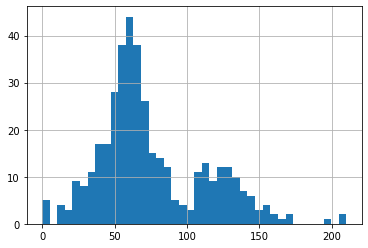

In [ ]:
frames_stat["NoValidFrames"].hist(bins=40)

##### 4.1.3.2 OpenPose

*   Pre-process extracted OpenPose keypoint data and generate train/validation dataset

In [ ]:
filepath = '/content/drive/MyDrive/Data/Project/OpenPose_Keypoints.zip'
!unzip -oq {filepath}

In [ ]:
subjects = ["S" + str(i).zfill(3) for i in range(1, 45)]
print(subjects)

['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010', 'S011', 'S012', 'S013', 'S014', 'S015', 'S016', 'S017', 'S018', 'S019', 'S020', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S029', 'S030', 'S031', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S038', 'S039', 'S040', 'S041', 'S042', 'S043', 'S044']


In [ ]:
import json
from pprint import pprint
import glob, os
import numpy as np
import pandas as pd

#Data path assumes that data is in format as ~/data/HAR_pose_activities/boxing/l01_c01_s01_a04_r01/pose, where boxing is replaced with whatever activity your pointing to
data_path = "/content/OpenPose"

openpose_train_x = []
openpose_train_y = []
openpose_val_x = []
openpose_val_y = []

frames_stat = pd.DataFrame()
subjects_valid=[]
subjects_invalid=[]

for subject in subjects:
  repetition_paths = [dirpaths for dirpaths, dirnames, filenames in os.walk(os.path.join(data_path,subject)) if not dirnames]
  for repetition_path in repetition_paths:
    repetition_kps = []
    os.chdir(repetition_path)

    repetition_filelist = sorted(glob.glob("*.json"))

    frame_list = []
    k = 3

    subject = subject[-2:]
    repetition = repetition_path.split("/")[-1]
    direction = "L" if repetition[1:][-1] == "L" else "R" if repetition[1:][-1] == "R" else "B"
    track = repetition[1:][-2] if repetition[1:][-1] in ["L", "R"] else repetition[1:][-1]

    for i, file in enumerate(repetition_filelist):
      with open(file) as data_file: 
        data = json.load(data_file)

        if(len(data["people"]) > 0):
          pose_keypoints = data["people"][0]["pose_keypoints_2d"]
          frame_list.append(i)
          del pose_keypoints[k-1::k]
          repetition_kps.append(process_joints(pose_keypoints))

    pct_validframes = round(((len(frame_list)/ len(data.keys())) * 100.0),2)

    frames_stat_one = pd.DataFrame.from_dict({"Subject": [subject],
                                                  "Track": [track],
                                                  "Direction": [direction],
                                                  "PctValidFrames": [pct_validframes],
                                                  "NoValidFrames": [len(frame_list)]})
    frames_stat = pd.concat([frames_stat, frames_stat_one], ignore_index=True)

    if(len(frame_list) > 50):
      if(("R1" in repetition_path) or ("R2" in repetition_path) or (("R3" in repetition_path) and (direction in ["B"] ))):
        openpose_train_x.append(repetition_kps[:50])
        openpose_train_y.append(OneHotEncodeY(int(subject), 44))
      elif(("R3" in repetition_path) and (direction in ["L"] )):
        openpose_val_x.append(repetition_kps[:50])
        openpose_val_y.append(OneHotEncodeY(int(subject), 44))  
      subjects_valid.append((int(subject), track, direction))
    else:
      subjects_invalid.append((int(subject), track, direction))

print(np.array(openpose_train_x, dtype=object).shape)
print(np.array(openpose_train_y, dtype=object).shape)
print(np.array(openpose_val_x, dtype=object).shape)
print(np.array(openpose_val_y, dtype=object).shape)


(201, 50, 36)
(201, 44)
(25, 50, 36)
(25, 44)


In [ ]:
valid_subjects = [subj[0] for subj in subjects_valid]
valid_subject_list = list(set(valid_subjects))
all_subject_list = [int(subject[-2:]) for subject in subjects]
set(all_subject_list) - set(valid_subject_list)

{16, 28, 36, 44}

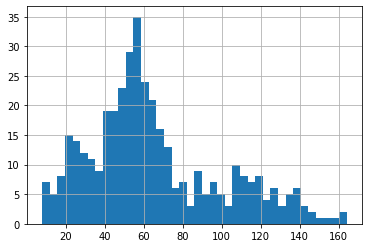

In [ ]:
frames_stat["NoValidFrames"].hist(bins=40)

#####   
**Note:**
Based on the keypoint data extraction results using AlphaPose/OpenPose:


*   Mean # of frames extracted from the video files is approximately *60* 
*   Using AlphaPose resulted in better keypoint data extraction as compared to OpenPose as can be observed in the higher number of video files with more than 50 frames extracted

### 4.2 Model Training

**Note:** 
*   Train various neural network models using train/validation datasets for person recognition
*   As the extracted keypoint data is sequential data,  LSTM-based (Long Short Term Memory) networks are selected (1-layer/stacked/bidirectional)

##### 4.2.1 Utility Functions

*   Define helper functions for model definintion and training

In [ ]:
# Create 1-layer LSTM model
def createSimpleLSTM(neurons=64):

    # Use Keras to create a Sequential model here with any layers that 
    # you'd like.
    #
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(50, 36)))
    model.add(BatchNormalization())

    # One or more repetitions of Dense layers
    model.add(Dense(44, activation='softmax'))
 
    model.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

# Create stacked 3-layer LSTM model
def createStackedLSTM(neurons=64):

    # Use Keras to create a Sequential model here with any layers that 
    # you'd like.
    #
    model = Sequential()

    layer2_neurons = int(neurons/2)
    layer3_neurons = int(neurons/4)
    #Stacked
    model.add(LSTM(neurons, activation='relu', return_sequences=True, input_shape=(50, 36)))
    model.add(BatchNormalization())
    model.add(LSTM(layer2_neurons, activation='relu', return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(layer3_neurons, activation='relu'))
    model.add(BatchNormalization())

    # One or more repetitions of Dense layers
    model.add(Dense(44, activation='softmax'))
 
    model.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

# Create 1-layer BiDirectional LSTM model
def createBiLSTM(neurons=64):

    # Use Keras to create a Sequential model here with any layers that 
    # you'd like.
    #
    model = Sequential()

    #Bidirectional
    model.add(Bidirectional(LSTM(neurons, activation='relu'), input_shape=(50, 36)))
    model.add(BatchNormalization())

    # One or more repetitions of Dense layers
    model.add(Dense(44, activation='softmax'))
 
    model.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

In [ ]:
# Utility function for model training
def train_model(train_x, train_y, val_x, val_y, epochs=50, neurons=64, modelType="BiLSTM"):
    # Create our model
    #
    if(modelType == "SimpleLSTM"):
      model = createSimpleLSTM(neurons)
    elif(modelType == "BiLSTM"):
      model = createBiLSTM(neurons)
    elif(modelType == "StackedLSTM"):
      model = createStackedLSTM(neurons)

    # Create the training folder
    #
    training_session_id = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
    training_session_folder = '/train_%s' % (training_session_id)
    os.makedirs(training_session_folder, exist_ok=True)

    # Configure the checkpoint and stop point.
    # This allows the training to save the best models and also stop the
    # training early if it detects that there are no improvements after
    # a long time.
    #
    callbacks_list = [
        ModelCheckpoint(
            filepath=training_session_folder + '/model.{epoch:04d}-val_acc-{val_accuracy:4.2f}-loss-{val_loss:4.2f}.h5',
            monitor='val_loss', save_best_only=True),
        #EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]

    # Train our model
    #
    start = time.time()
    history = model.fit(x=np.array(train_x), y=np.array(train_y), batch_size=32, epochs=epochs, verbose=1, callbacks=callbacks_list, validation_data=(np.array(val_x), np.array(val_y)))
    end = time.time()
    train_time = end - start
    
    return model, history, train_time

##### 4.2.2 AlphaPose

*   Train various LSTM neural network models (simple/stacked/bidirectional) using train/validation dataset generated from pre-processed ***AlphaPose*** keypoint data from section 3.2

###### 4.2.2.1 Simple LSTM

In [ ]:
alphapose_model_simple, alphapose_history_simple, alphapose_train_time_simple = train_model(alphapose_train_x, alphapose_train_y, alphapose_val_x, alphapose_val_y, 50, 64, "SimpleLSTM")

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 64)                25856     
_________________________________________________________________
batch_normalization_29 (Batc (None, 64)                256       
_________________________________________________________________
dense_21 (Dense)             (None, 44)                2860      
Total params: 28,972
Trainable params: 28,844
Non-trainable params: 128
_________________________________________________________________
Epoch 1/50
9/9 [==============================] - 2s 55ms/step - loss: 3.9271 - accuracy: 0.0394 - val_loss: 3.8090 - val_accuracy: 0.0000e+00
Epoch 2/50
9/9 [==============================] - 1s 69ms/step - loss: 3.5647 - accuracy: 0.1139 - val_loss: 3.7926 - val_accuracy: 0.0323
Epoch 3/50
9/9 [==============================] - 0s 10ms/step - loss: 3.2376 - accuracy: 0.207

###### 4.2.2.2 Stacked LSTM

In [ ]:
alphapose_model_stacked, alphapose_history_stacked, alphapose_train_time_stacked = train_model(alphapose_train_x, alphapose_train_y, alphapose_val_x, alphapose_val_y, 50, 64, "StackedLSTM")

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 50, 64)            25856     
_________________________________________________________________
batch_normalization_30 (Batc (None, 50, 64)            256       
_________________________________________________________________
lstm_31 (LSTM)               (None, 50, 32)            12416     
_________________________________________________________________
batch_normalization_31 (Batc (None, 50, 32)            128       
_________________________________________________________________
lstm_32 (LSTM)               (None, 16)                3136      
_________________________________________________________________
batch_normalization_32 (Batc (None, 16)                64        
_________________________________________________________________
dense_22 (Dense)             (None, 44)              

###### 4.2.2.3 BiDirectional LSTM

In [ ]:
alphapose_model_BiDirectional, alphapose_history_BiDirectional, alphapose_train_time_BiDirectional = train_model(alphapose_train_x, alphapose_train_y, alphapose_val_x, alphapose_val_y, 50, 64, "BiLSTM")

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 128)               51712     
_________________________________________________________________
batch_normalization_33 (Batc (None, 128)               512       
_________________________________________________________________
dense_23 (Dense)             (None, 44)                5676      
Total params: 57,900
Trainable params: 57,644
Non-trainable params: 256
_________________________________________________________________
Epoch 1/50
9/9 [==============================] - 3s 172ms/step - loss: 3.9683 - accuracy: 0.0313 - val_loss: 3.8053 - val_accuracy: 0.0323
Epoch 2/50
9/9 [==============================] - 1s 137ms/step - loss: 3.5347 - accuracy: 0.0881 - val_loss: 3.7986 - val_accuracy: 0.0323
Epoch 3/50
9/9 [==============================] - 1s 148ms/step - loss: 3.3497 - accuracy: 0.1654

##### 4.2.3 OpenPose

*   Train various LSTM neural network models (simple/stacked/bidirectional) using train/validation dataset generated from pre-processed ***OpenPose*** keypoint data from section 3.2

###### 4.2.3.1 Simple LSTM

In [ ]:
openpose_model_simple, openpose_history_simple, openpose_train_time_simple = train_model(openpose_train_x, openpose_train_y, openpose_val_x, openpose_val_y, 50, 512, "SimpleLSTM")

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 512)               1124352   
_________________________________________________________________
batch_normalization_23 (Batc (None, 512)               2048      
_________________________________________________________________
dense_17 (Dense)             (None, 44)                22572     
Total params: 1,148,972
Trainable params: 1,147,948
Non-trainable params: 1,024
_________________________________________________________________
Epoch 1/50
7/7 [==============================] - 2s 82ms/step - loss: 4.1689 - accuracy: 0.0773 - val_loss: 3.6290 - val_accuracy: 0.0400
Epoch 2/50
7/7 [==============================] - 0s 20ms/step - loss: 1.8042 - accuracy: 0.5043 - val_loss: 3.4423 - val_accuracy: 0.1600
Epoch 3/50
7/7 [==============================] - 0s 20ms/step - loss: 1.2145 - accuracy: 0

###### 4.2.3.2 Stacked LSTM

In [ ]:
openpose_model_stacked, openpose_history_stacked, openpose_train_time_stacked = train_model(openpose_train_x, openpose_train_y, openpose_val_x, openpose_val_y, 50, 512, "StackedLSTM")

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 50, 512)           1124352   
_________________________________________________________________
batch_normalization_24 (Batc (None, 50, 512)           2048      
_________________________________________________________________
lstm_25 (LSTM)               (None, 50, 256)           787456    
_________________________________________________________________
batch_normalization_25 (Batc (None, 50, 256)           1024      
_________________________________________________________________
lstm_26 (LSTM)               (None, 128)               197120    
_________________________________________________________________
batch_normalization_26 (Batc (None, 128)               512       
_________________________________________________________________
dense_18 (Dense)             (None, 44)              

###### 4.2.3.3 BiDirectional LSTM

In [ ]:
openpose_model_BiDirectional, openpose_history_BiDirectional, openpose_train_time_BiDirectional = train_model(openpose_train_x, openpose_train_y, openpose_val_x, openpose_val_y, 50, 512, "BiLSTM")

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1024)              2248704   
_________________________________________________________________
batch_normalization_11 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_7 (Dense)              (None, 44)                45100     
Total params: 2,297,900
Trainable params: 2,295,852
Non-trainable params: 2,048
_________________________________________________________________
Epoch 1/50
7/7 [==============================] - 3s 192ms/step - loss: 4.4992 - accuracy: 0.0423 - val_loss: 55.6831 - val_accuracy: 0.0400
Epoch 2/50
7/7 [==============================] - 1s 152ms/step - loss: 3.9558 - accuracy: 0.0430 - val_loss: nan - val_accuracy: 0.0400
Epoch 3/50
7/7 [==============================] - 1s 141ms/step - loss: nan - accuracy: 0.03

### 4.3 Model Evaluation

*   Evaluate trained neural network models based on defined metrics

**Note:** Performance was evaluated using the following metrics:
>*   accuracy and loss curves
>*   confusion matrix 
>*   classification report

#### 4.3.1 Utility Functions

*   Define helper functions for model evaluation (accuracy/loss curves, confusion matrix, classification report)

In [ ]:
import matplotlib.pyplot as plt

# Display the train/test accuracy/loss of the trained model
def display_training_loss_and_accuracy(history):
    
    plt.figure(figsize=(20,4))
    
    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()    

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
 
# Display the confusion matrix/classification report of the trained model
def display_classification_confusion_matrix(keras_model, x_train, y_train, x_test, y_test, labels):
    
    '''
    x_train = []
    x_test = []
    y_train = []
    y_test = []
    '''
    pred_y_train = []
    pred_y_test = []

    pred_y_train = keras_model.predict(x_train)

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    pred_y_train = np.array(pred_y_train)

    pred_y_test = keras_model.predict(x_test)

    x_test = np.array(x_test)
    y_test = np.array(y_test)
    pred_y_test = np.array(pred_y_test)

    #test_generator.on_epoch_end()

    plt.figure(figsize=(20,6))  

    labels = np.array(labels)

    # Convert the target labels into the categorical index
    #
    y_train_index = y_train.argmax(axis=1)
    pred_y_train_index = pred_y_train.argmax(axis=1)
    y_test_index = y_test.argmax(axis=1)
    pred_y_test_index = pred_y_test.argmax(axis=1)
    
    # Print the first Confusion Matrix for the training data
    #
    cm = confusion_matrix(y_train_index, pred_y_train_index)

    #cm_df = pd.DataFrame(cm, labels, labels)
    cm_df = pd.DataFrame(cm)          
    plt.subplot(1, 2, 1)
    plt.title('Confusion Matrix (Train Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')        
    
    # Print the second Confusion Matrix for the test data
    #    
    cm = confusion_matrix(y_test_index, pred_y_test_index)
    
    #cm_df = pd.DataFrame(cm, labels, labels) 
    cm_df = pd.DataFrame(cm)         
    plt.subplot(1, 2, 2)
    plt.title('Confusion Matrix (Test Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')        
    
    plt.show()

    # Finally display the classification reports
    #
    print ("Test Data:")
    print ("--------------------------------------------------------")
    print(classification_report(y_test_index, pred_y_test_index, target_names=labels))

#### 4.3.2 Training Loss/Accuracy


*   Generate train/loss accuracy curves for various trained models for comparison purposes

##### 4.3.2.1 AlphaPose

*   Generate train/loss accuracy curves for trained models from section 4.2.2

###### 4.3.2.1.1 Simple

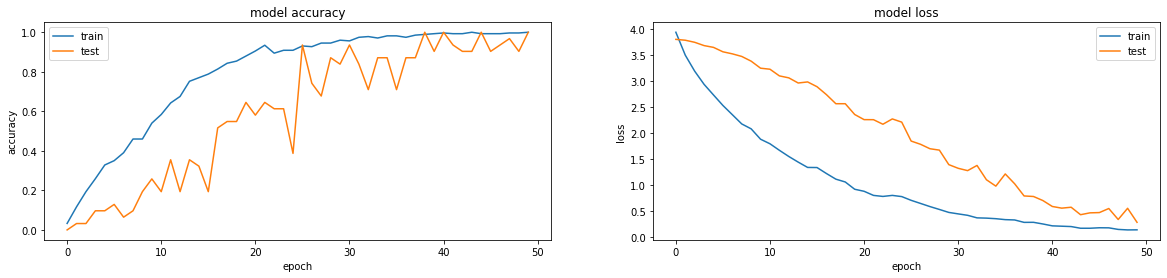

In [ ]:
display_training_loss_and_accuracy(alphapose_history_simple)

###### 4.3.2.1.2 Stacked

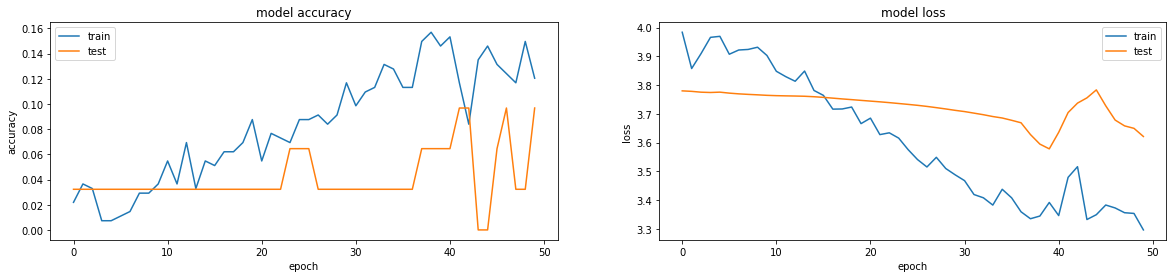

In [ ]:
display_training_loss_and_accuracy(alphapose_history_stacked)

###### 4.3.2.1.3 BiDirectional

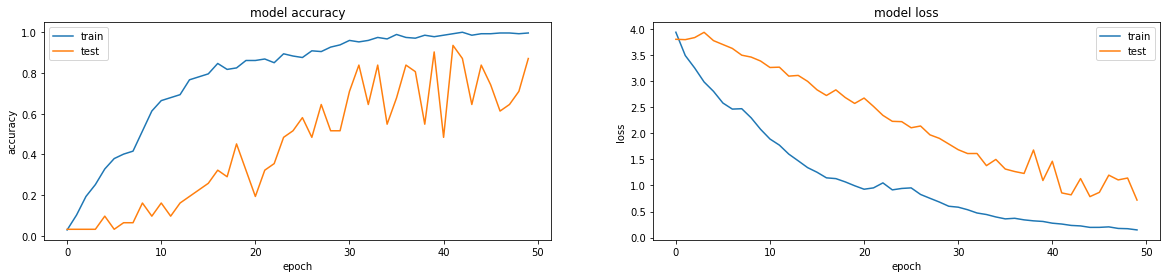

In [ ]:
display_training_loss_and_accuracy(alphapose_history_BiDirectional)

##### 4.3.2.2 OpenPose

*   Generate train/loss accuracy curves for trained models from section 4.2.3

###### 4.3.2.2.1 Simple

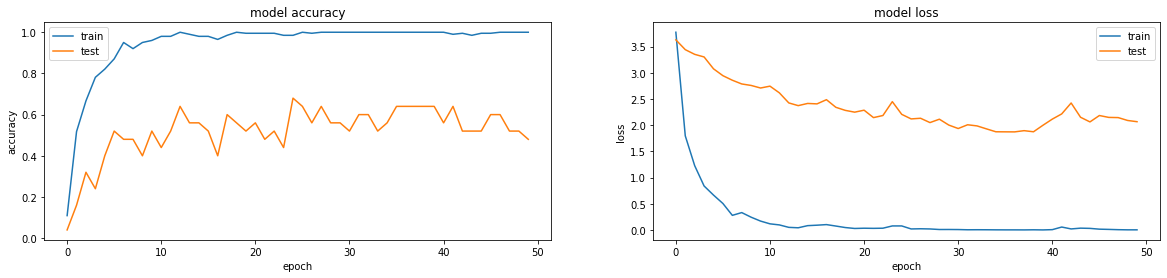

In [ ]:
display_training_loss_and_accuracy(openpose_history_simple)

###### 4.3.2.2.2 Stacked

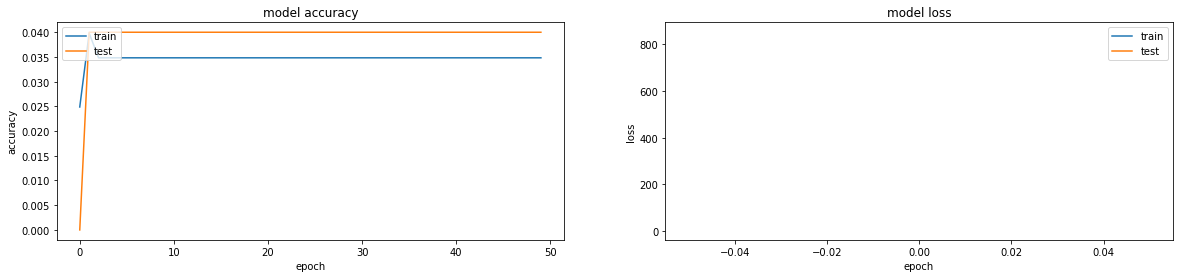

In [ ]:
display_training_loss_and_accuracy(openpose_history_stacked)

###### 4.3.2.2.3 BiDirectional

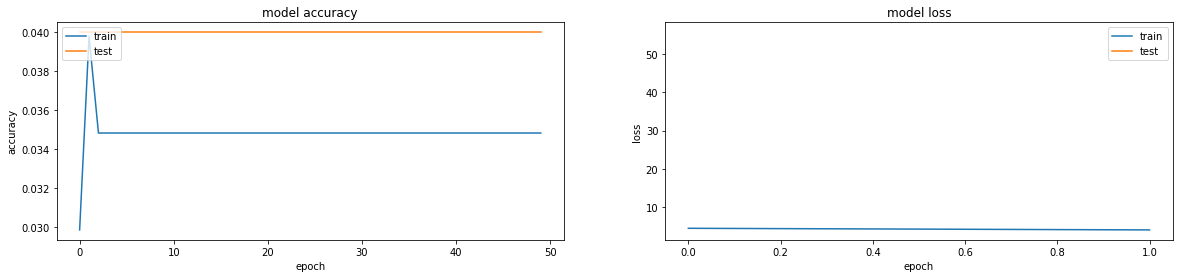

In [ ]:
display_training_loss_and_accuracy(openpose_history_BiDirectional)

#### 4.3.3 Confusion Matrix/ Classification Report

*   Generate confusion matrix/ classification report for various trained models for comparison purposes

##### 4.3.3.1 AlphaPose

*   Generate confusion matrix/classification report for trained models from section 4.2.2

###### 4.3.3.1.1 Simple

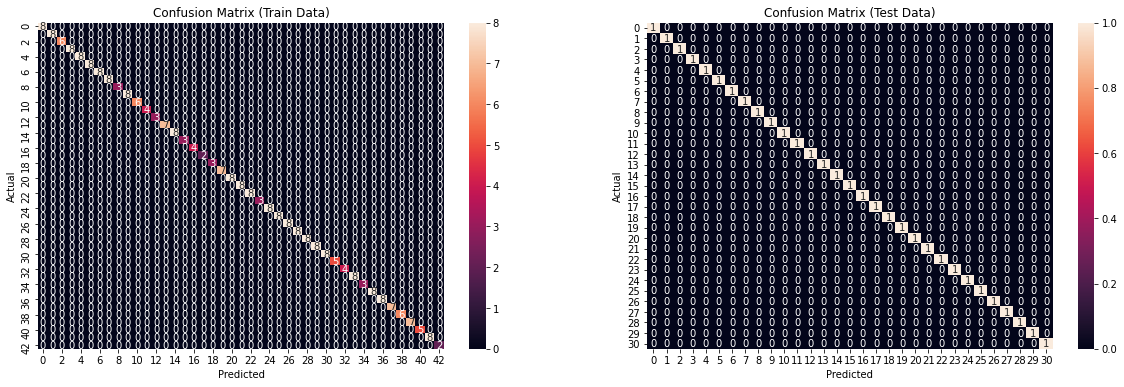

Test Data:
--------------------------------------------------------
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         1
          17 

In [ ]:
labels=[str(i) for i in range(1,32)]
display_classification_confusion_matrix(alphapose_model_simple, np.array(alphapose_train_x), np.array(alphapose_train_y), np.array(alphapose_val_x), np.array(alphapose_val_y), labels)

###### 4.3.3.1.2 Stacked

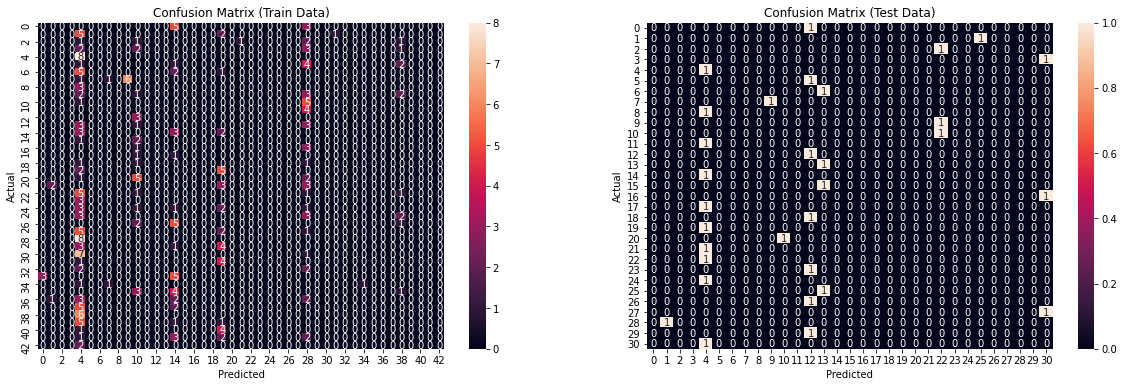

Test Data:
--------------------------------------------------------
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.10      1.00      0.18         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.14      1.00      0.25         1
          14       0.25      1.00      0.40         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
          17 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
labels=[str(i) for i in range(1,32)]
display_classification_confusion_matrix(alphapose_model_stacked, np.array(alphapose_train_x), np.array(alphapose_train_y), np.array(alphapose_val_x), np.array(alphapose_val_y), labels)

###### 4.3.3.1.3 BiDirectional

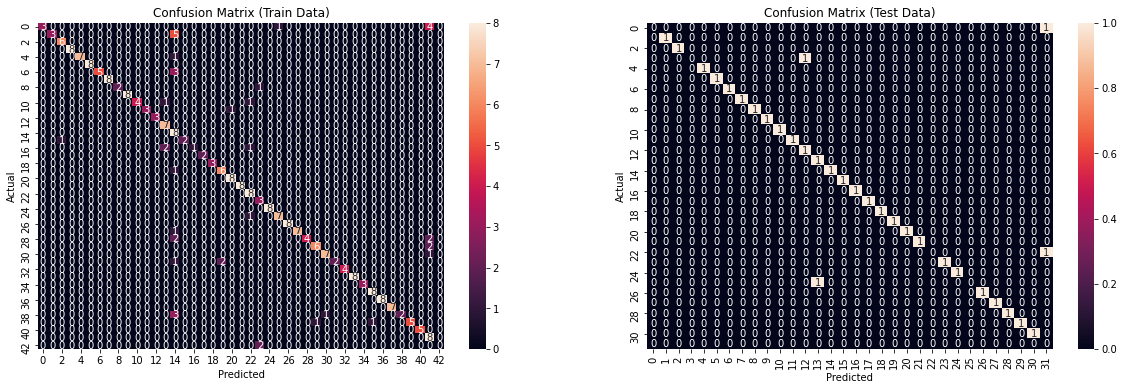

Test Data:
--------------------------------------------------------
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       0.50      1.00      0.67         1
          14       0.50      1.00      0.67         1
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         1
          17 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
labels=[str(i) for i in range(1,33)]
display_classification_confusion_matrix(alphapose_model_BiDirectional, np.array(alphapose_train_x), np.array(alphapose_train_y), np.array(alphapose_val_x), np.array(alphapose_val_y), labels)

##### 4.3.3.2 OpenPose

*   Generate confusion matrix/classification report for trained models from section 4.2.3

###### 4.3.3.2.1 Simple

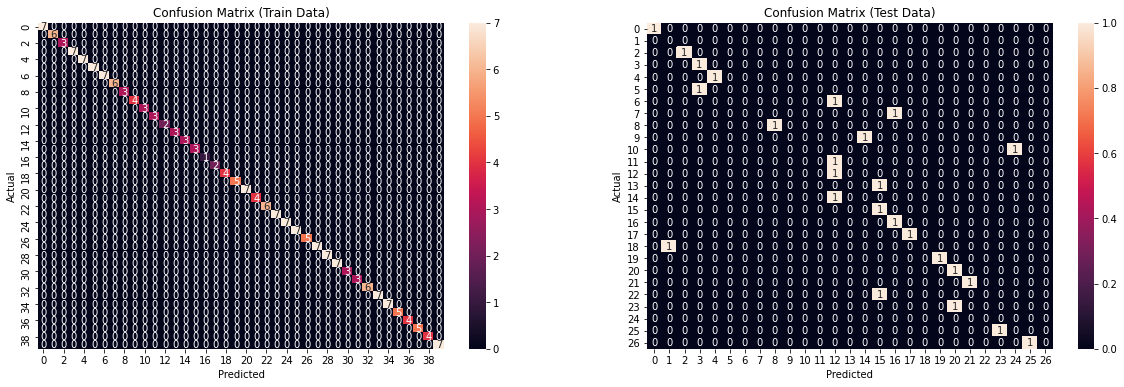

Test Data:
--------------------------------------------------------
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         0
           3       1.00      1.00      1.00         1
           4       0.50      1.00      0.67         1
           5       1.00      1.00      1.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       1.00      1.00      1.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.25      1.00      0.40         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.33      1.00      0.50         1
          17 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
labels=[str(i) for i in range(1,28)]
display_classification_confusion_matrix(openpose_model_simple, np.array(openpose_train_x), np.array(openpose_train_y), np.array(openpose_val_x), np.array(openpose_val_y), labels)

###### 4.3.3.2.2 Stacked

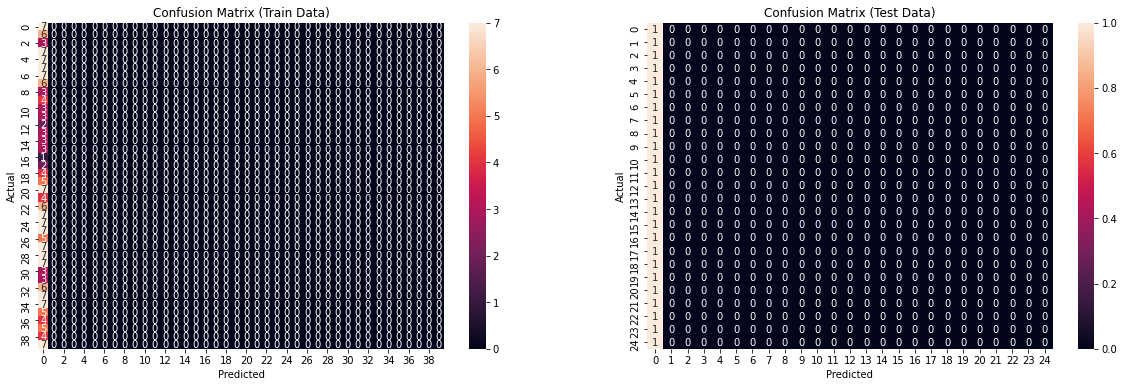

Test Data:
--------------------------------------------------------
              precision    recall  f1-score   support

           1       0.04      1.00      0.08         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
          17 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
labels=[str(i) for i in range(1,26)]
display_classification_confusion_matrix(openpose_model_stacked, np.array(openpose_train_x), np.array(openpose_train_y), np.array(openpose_val_x), np.array(openpose_val_y), labels)

###### 4.3.3.2.3 BiDirectional

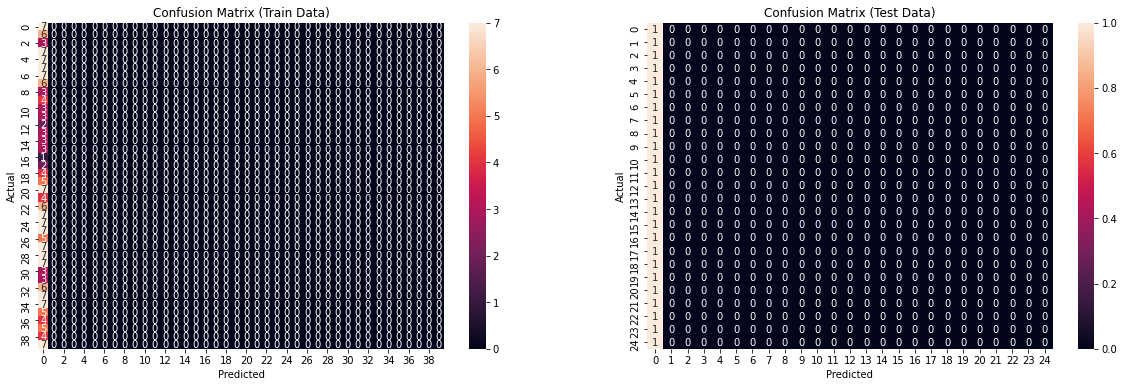

Test Data:
--------------------------------------------------------
              precision    recall  f1-score   support

           1       0.04      1.00      0.08         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
          17 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
labels=[str(i) for i in range(1,26)]
display_classification_confusion_matrix(openpose_model_BiDirectional, np.array(openpose_train_x), np.array(openpose_train_y), np.array(openpose_val_x), np.array(openpose_val_y), labels)

#### 4.3.4 Training Time

*   Generate barplot for comparing training times for the various trained models

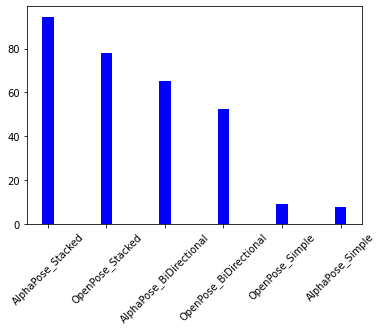

In [ ]:
train_times = {
    'AlphaPose_Simple' : alphapose_train_time_simple,
    'AlphaPose_Stacked' : alphapose_train_time_stacked,
    'AlphaPose_BiDirectional' : alphapose_train_time_BiDirectional,
    'OpenPose_Simple' : openpose_train_time_simple,
    'OpenPose_Stacked' : openpose_train_time_stacked,
    'OpenPose_BiDirectional' : openpose_train_time_BiDirectional
}

train_times_sorted = {k: v for k, v in sorted(train_times.items(), key=lambda item: -item[1])}

keys = [key for key in train_times_sorted.keys()]
values = [value for value in train_times_sorted.values()]
fig, ax = plt.subplots()
ax.bar(np.arange(len(keys)), [value for value in values],
       width=0.2, color='b', align='center')
ax.set_xticklabels(keys, rotation = 45)
ax.set_xticks(np.arange(len(keys)))
plt.show()

####   
**Note:** Based on the results above, the ***1-layer LSTM model using 64 neurons per layer with AlphaPose extracted keypoint data*** produced the best performance as compared to alternative models using stacked/bidirectional LSTMs or OpenPose extracted keypoint data

### 4.4 Model Tuning

**Note:**
*   To evaluate the use of different number of neurons per layer on the model performance, 1-layer LSTM models using AlphaPose extracted keypoint data with 32 and 128 number of neurons in layer are trained and performance compared to that using original 64 number of neurons in layer

#### 4.4.1 32
*   Train 1-layer LSTM model using 32 neurons per layer



In [ ]:
alphapose_model_simple_32, alphapose_history_simple_32, alphapose_train_time_simple_32 = train_model(alphapose_train_x, alphapose_train_y, alphapose_val_x, alphapose_val_y, 50, 32, "SimpleLSTM")

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 32)                8832      
_________________________________________________________________
batch_normalization_34 (Batc (None, 32)                128       
_________________________________________________________________
dense_24 (Dense)             (None, 44)                1452      
Total params: 10,412
Trainable params: 10,348
Non-trainable params: 64
_________________________________________________________________
Epoch 1/50
9/9 [==============================] - 2s 58ms/step - loss: 3.9882 - accuracy: 0.0418 - val_loss: 3.8041 - val_accuracy: 0.0000e+00
Epoch 2/50
9/9 [==============================] - 0s 10ms/step - loss: 3.7530 - accuracy: 0.0568 - val_loss: 3.7849 - val_accuracy: 0.0323
Epoch 3/50
9/9 [==============================] - 0s 10ms/step - loss: 3.5400 - accuracy: 0.1201

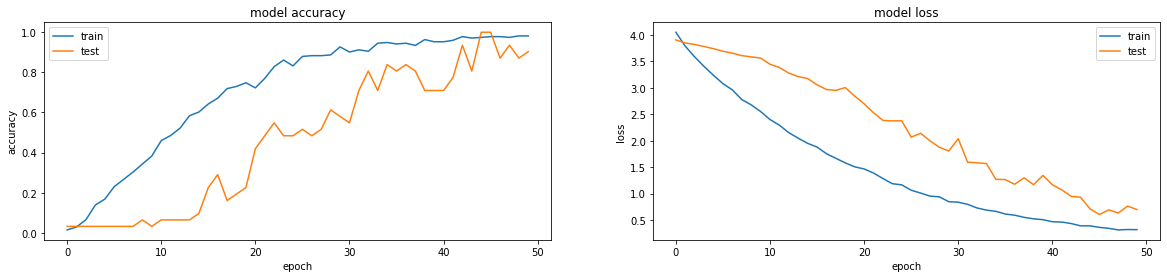

In [ ]:
display_training_loss_and_accuracy(alphapose_history_BiDirectional_32)

#### 4.4.2 128
*   Train 1-layer LSTM model using 128 neurons per layer

In [ ]:
alphapose_model_simple_128, alphapose_history_simple_128, alphapose_train_time_simple_128 = train_model(alphapose_train_x, alphapose_train_y, alphapose_val_x, alphapose_val_y, 50, 128, "SimpleLSTM")

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 128)               84480     
_________________________________________________________________
batch_normalization_35 (Batc (None, 128)               512       
_________________________________________________________________
dense_25 (Dense)             (None, 44)                5676      
Total params: 90,668
Trainable params: 90,412
Non-trainable params: 256
_________________________________________________________________
Epoch 1/50
9/9 [==============================] - 2s 58ms/step - loss: 3.9442 - accuracy: 0.0520 - val_loss: 3.7958 - val_accuracy: 0.0323
Epoch 2/50
9/9 [==============================] - 0s 12ms/step - loss: 3.0882 - accuracy: 0.2680 - val_loss: 3.7478 - val_accuracy: 0.0645
Epoch 3/50
9/9 [==============================] - 0s 12ms/step - loss: 2.7213 - accuracy: 0.3037 - 

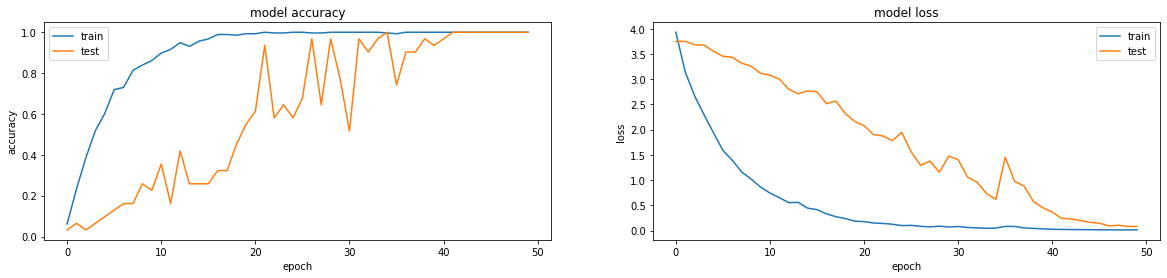

In [ ]:
display_training_loss_and_accuracy(alphapose_history_BiDirectional_128)

####   
**Note:** Based on the results above, the original 1-layer LSTM model using 64 neurons per layer produced the best performance as compared to alternative models using 32/ 128 neurons per layer.

### 4.5 Model Save/Download
*   Export and save trained model

#### 4.5.1 Utility Functions
*   Define helper functions for saving trained model

In [ ]:
def saveModel(model, name, savepath):
  !mkdir -p {savepath}
  model.save(savepath)
  !zip /content/models/{name}.zip -r {savepath}

#### 4.5.2 Save Model
*   Save trained 1-layer LSTM model (with 64 neurons) using AlphaPose extracted keypoint data to file 

In [ ]:
saveModel(alphapose_model_simple, "Alphapose_model_simple", "/content/models/AlphaPose")

INFO:tensorflow:Assets written to: /content/models/AlphaPose/assets


INFO:tensorflow:Assets written to: /content/models/AlphaPose/assets


  adding: content/models/AlphaPose/ (stored 0%)
  adding: content/models/AlphaPose/assets/ (stored 0%)
  adding: content/models/AlphaPose/saved_model.pb (deflated 90%)
  adding: content/models/AlphaPose/variables/ (stored 0%)
  adding: content/models/AlphaPose/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/models/AlphaPose/variables/variables.index (deflated 63%)


### 4.6 Model Testing

#### 4.6.1 Upload test video
*   Upload test video using file browse dialog

In [ ]:
from google.colab import files

! mkdir /content/output

os.chdir("/content/output")
uploaded = files.upload()

mkdir: cannot create directory ‘/content/output’: File exists


Saving S043_T3_R.mp4 to S043_T3_R.mp4


#### 4.6.2 Extract Keypoint Data
*   Use AlphaPose to extract keypoint data from uploaded test video

In [ ]:
file = "/content/output/S043_T3_R.mp4"

os.chdir('/content/AlphaPose')
! python scripts/demo_inference.py --cfg configs/coco/resnet/256x192_res50_lr1e-3_1x.yaml --checkpoint pretrained_models/fast_res50_256x192.pth --format open --video '{file}' --outdir /content/output --save_video --save_img

Loading pose model from pretrained_models/fast_res50_256x192.pth...
Loading YOLO model..
 17% 15/87 [00:02<00:34,  2.10it/s]Could not find encoder for codec id 27: Encoder not found
Try to use other video encoders...
100% 87/87 [00:07<00:00, 11.50it/s]
===========================> Finish Model Running.
===========================> Rendering remaining images in the queue...
===========================> If this step takes too long, you can enable the --vis_fast flag to use fast rendering (real-time).
===========================> Rendering remaining 47 images in the queue...
===========================> Rendering remaining 37 images in the queue...
===========================> Rendering remaining 26 images in the queue...
===========================> Rendering remaining 16 images in the queue...
===========================> Rendering remaining 0 images in the queue...
Results have been written to json.


#### 4.6.3 Keypoint Data Post-processing

In [ ]:
file = "/content/output/alphapose-results.json"
repetition_kps = []
with open(file) as data_file: 
  data = json.load(data_file)
  for i, key in enumerate(data.keys()):
    no_of_frames = len(data[key]["people"][0]["pose_keypoints_2d"])
    pose_keypoints = data[key]["people"][0]["pose_keypoints_2d"]
    # remove every third element (confidence score) from pose_keypoints
    del pose_keypoints[k-1::k]
    repetition_kps.append(process_joints(pose_keypoints))

print(np.array(repetition_kps).shape)

(63, 36)


In [ ]:
input = np.array(repetition_kps[:50]).reshape(1,50,36)

#### 4.6.4 Model Predict
*   Predict person in test video using trained model

In [ ]:
loaded_model = tf.keras.models.load_model('/content/models/AlphaPose')

In [ ]:
subject_pred = np.argmax(loaded_model.predict(input)) + 1
print("Predicted Subject: {}".format(int(subject_pred)))

Predicted Subject: 43


##    
**Note:** Trained model was able to predict the correct person in test video

## 5 Model Deployment
*   User interaction via Flask web application. Source code available at:
> https://github.com/yuanher/GaitRecognition/tree/main/3.%20Web_App


*   The web app directory structure is as follows:
```
<root>
|
|----app (web server related files)
|     |
|     |----assets
|     |       |------xxx.mp4 (used for storing uploaded video files)
|     |
|     |----templates
|     |       |------file.html (web page for user interaction)
|     |
|     |----model (trained model SavedModel files)
|     |
|     |----main.py (flask)
|     |----requirements.txt (package requirements for web server)
|     |----uwsgi.ini (WSGI configuration file)
|     
|----docker-compose.yml (docker-compose file)
|----Dockerfile (Dockerfile for web server)
```

### 5.1 Deploy from source files

*   To run the web application from the source files, follow the steps below:
>*  Download the source file from the git repository link above
>*  From the command prompt, navigate to the directory where the *main.py* file is located
>*  Install the prerequisite requirements by executing : *pip install -r requirements.txt*
>*  Run the flask web appplcation by executing : *python main.py*
>*  Open the web browser and navigate to *http://localhost*

### 5.2 Deploy from docker image

*   Alternatively, docker image available at:
> https://hub.docker.com/repository/docker/yuanher/webapp
*   To use the docker image, execute the following commands at the command prompt:
>* *docker pull yuanher/webapp*
>* *docker run -d --name webapp -p 80:80 yuanher/webapp*